=== Classification Report (Gaussian Naive Bayes) ===
              precision    recall  f1-score   support

   malignant      0.958     0.868     0.911        53
      benign      0.926     0.978     0.951        90

    accuracy                          0.937       143
   macro avg      0.942     0.923     0.931       143
weighted avg      0.938     0.937     0.936       143



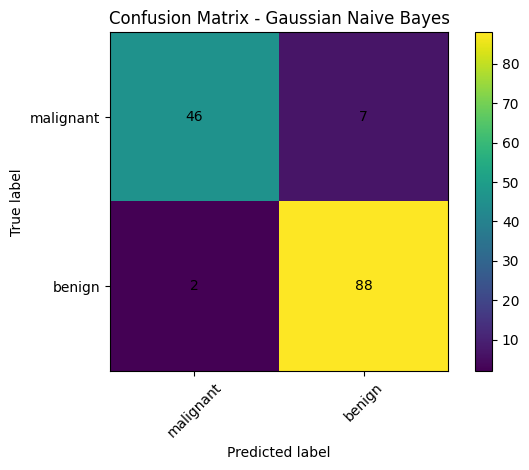

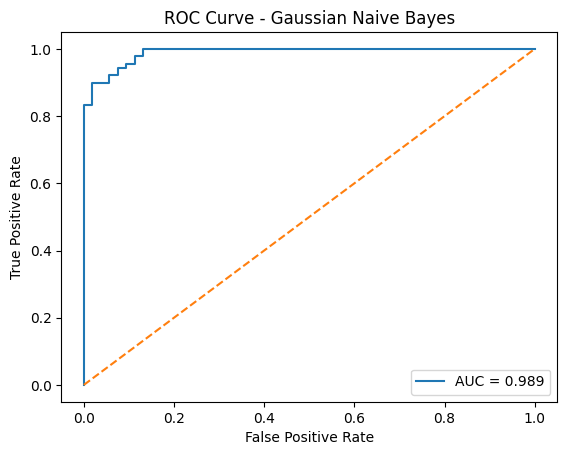


=== Top discriminative features ===
             feature  malignant_mean  benign_mean  malignant_std  benign_std  abs_standardized_mean_diff
worst concave points        0.183506     0.072858       0.048056    0.035605                    2.616347
 mean concave points        0.087273     0.024949       0.033583    0.015598                    2.380296
     worst perimeter      140.599937    86.677903      29.346102   13.664982                    2.355679
        worst radius       21.020566    13.333382       4.265329    1.999010                    2.307877
      mean perimeter      114.931572    77.694607      21.557244   11.791234                    2.143194
         mean radius       17.402767    12.093618       3.160629    1.782843                    2.069085
          worst area     1404.677987   555.623970     583.555047  164.790664                    1.980195
           mean area      969.403145   459.198876     356.887506  134.279563                    1.892245
      mean concavi

In [1]:
# Gaussian Naive Bayes on a real-world dataset (Breast Cancer Wisconsin)
# - Trains, evaluates, and visualizes (confusion matrix + ROC curve)
# - Lists most discriminative features (by standardized mean difference)
#
# How to run:
#   pip install scikit-learn matplotlib pandas numpy
#   python naive_bayes_breast_cancer.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

def main():
    # 1) Load real-world dataset
    data = load_breast_cancer()
    X = data.data
    y = data.target  # 0 = malignant, 1 = benign
    feature_names = data.feature_names
    target_names = data.target_names

    # 2) Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )

    # 3) Train Gaussian Naive Bayes
    model = GaussianNB()
    model.fit(X_train, y_train)

    # 4) Evaluate
    y_pred = model.predict(X_test)
    print("=== Classification Report (Gaussian Naive Bayes) ===")
    print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

    # 5) Confusion Matrix visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix - Gaussian Naive Bayes')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    # Annotate counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.tight_layout()
    plt.show()

    # 6) ROC Curve visualization
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]  # probability of class "benign"
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Gaussian Naive Bayes')
        plt.legend(loc='lower right')
        plt.show()

    # 7) Most discriminative features (by standardized mean difference between classes)
    X_train_mal = X_train[y_train == 0]  # malignant
    X_train_ben = X_train[y_train == 1]  # benign

    mean_mal = X_train_mal.mean(axis=0)
    std_mal = X_train_mal.std(axis=0, ddof=1)
    mean_ben = X_train_ben.mean(axis=0)
    std_ben = X_train_ben.std(axis=0, ddof=1)

    pooled_std = np.sqrt((std_mal**2 + std_ben**2) / 2.0)
    pooled_std_safe = np.where(pooled_std == 0, 1e-8, pooled_std)
    std_mean_diff = (mean_ben - mean_mal) / pooled_std_safe
    abs_diff = np.abs(std_mean_diff)

    top_idx = np.argsort(-abs_diff)[:12]  # top features

    top_features_df = pd.DataFrame({
        "feature": feature_names[top_idx],
        "malignant_mean": mean_mal[top_idx],
        "benign_mean": mean_ben[top_idx],
        "malignant_std": std_mal[top_idx],
        "benign_std": std_ben[top_idx],
        "abs_standardized_mean_diff": abs_diff[top_idx],
    }).reset_index(drop=True)

    print("\n=== Top discriminative features ===")
    print(top_features_df.to_string(index=False))

if __name__ == "__main__":
    main()
